# $$\text{Guia de Prática 6:}$$

In [1]:
import numpy as np
import control as ct
import matplotlib.pyplot as plt
import scienceplots

# Configurações de plot:
plt.style.use([
    'grid',
    'retro'
])
#plt.rcParams['lines.linewidth'] = 2
#plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = (10, 8)
colors = ['C0', 'C1', 'C2', 'C4', 'C5', 'black', 'pink', 'y']

### $$\text{Definição do sistema em espaço de estados:}$$

In [2]:
A = np.array([
    [-8.42, -21.4],
    [1, 0],
])

B = np.array([1, 0])[:, np.newaxis]

C = np.array([0, 16.2])

ss = ct.ss(A, B, C, np.zeros(1))

### $$\text{Obtendo os ganhos do PI-like:}$$

In [3]:
#Definição dos polos desejados:
pd = np.array([-60, (-5.72+7.62j), (-5.72-7.62j)], dtype=np.complex_)

#Definição das matrizes aumentadas:
Atil = np.block([[A, np.zeros((len(A),1))], [-C, np.array([0])]])
Btil = np.vstack((B, np.array([0])))
Ctil = np.hstack((C, np.array([0])))

k = ct.place(Atil, Btil, pd)[0]

k

array([  63.02      ,  755.7828    , -336.23259259])

### $$\text{Projeto do Observador:}$$

In [4]:
s = ct.tf('s')

#Polos do observador:
po = []
for p in pd[1:]:
    po.append(complex(10*p.real, p.imag))

#Coeficientes do polinômio característico da malha fechada:
pol = 1
for p in pd[1:]:
    pol *= (s-p)
cmf = np.flip(np.array(pol.num, dtype=np.int_)[0][0])[:-1]

#Coeficientes do polinômio característico do observador:
pol = 1
for p in po:
    pol *= (s-p)
cob = np.flip(np.array(pol.num, dtype=np.int_)[0][0])[:-1]

L = (cob-cmf)[:, np.newaxis]

L

C:\Users\erick\AppData\Local\Temp\ipykernel_18916\2006811020.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  cmf = np.flip(np.array(pol.num, dtype=np.int_)[0][0])[:-1]
C:\Users\erick\AppData\Local\Temp\ipykernel_18916\2006811020.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  cob = np.flip(np.array(pol.num, dtype=np.int_)[0][0])[:-1]


array([[3239],
       [ 103]])

### $$\text{Definição do sistema com observador em malha fechada:}$$

In [5]:
#Função de saturação:
def sat(sig, lim_inf, lim_sup):
    if(sig>lim_sup):
        sig = lim_sup
    if(sig<lim_inf):
        sig = lim_inf
    return sig

#Função de iteração:
def model_update(t, st, ins, params):
    #Demultiplex dos sinais:
    X = st[:len(A)][:, np.newaxis]
    xa = st[len(A)]
    X_ = st[len(A)+1:][:, np.newaxis]
    ka = -k[-1]
    r = ins[0]-params[1] #Desconta o sinal de equilíbrio
    d = ins[1]

    #Cálculo do sinal de controle (a partir dos estados estimados):
    u = (r-(k[:-1]@X_)+(ka*xa))[0]+d
    u = sat(u, 0, 100)

    #Sistema em malha fechada (realimentação dos estados estimados):
    Xdot = A@X+B*u

    #Saída do sistema:
    y = (C@X)[0]
    #Cálculo do erro de seguimento:
    e = (r-y)
    #Primitiva do estado aumentado:
    xadot = e

    #Saída estimada:
    y_ = (C@X_)[0]
    #Cálculo do erro de estimação:
    ex_ = (y-y_)
    #Observador em malha fechada:
    X_dot = A@X_+B*u+L*ex_

    #Concatenando todas as derivadas dos estados:
    dstates = np.hstack([Xdot.T[0], [xadot], X_dot.T[0]])
    
    return dstates

def model_output(t, st, ins, params):
    #Demultiplex dos sinais:
    X = st[:len(A)]
    xa = st[len(A)]
    X_ = st[len(A)+1:]
    ka = -k[-1]
    r = ins[0]-params[1]
    d = ins[1]
    ueq = params[0]
    pop = params[1]
    xeq = params[2:]

    #Cálculo do sinal de controle:
    u = (r-(k[:-1]@X_)+(ka*xa))+ueq
    u = sat(u, 0, 100)

    #Cálculo da saída do sistema:
    y = (C@X)+pop

    return np.hstack([u, np.array([y]), st+xeq])

out = ['u', 'y']
for i in range(len(A)):
    out.append(f'x{i+1}')
out.append('xa')
for i in range(len(A)):
    out.append(f'x_{i+1}')

### $$\text{Simulação do sistema:}$$

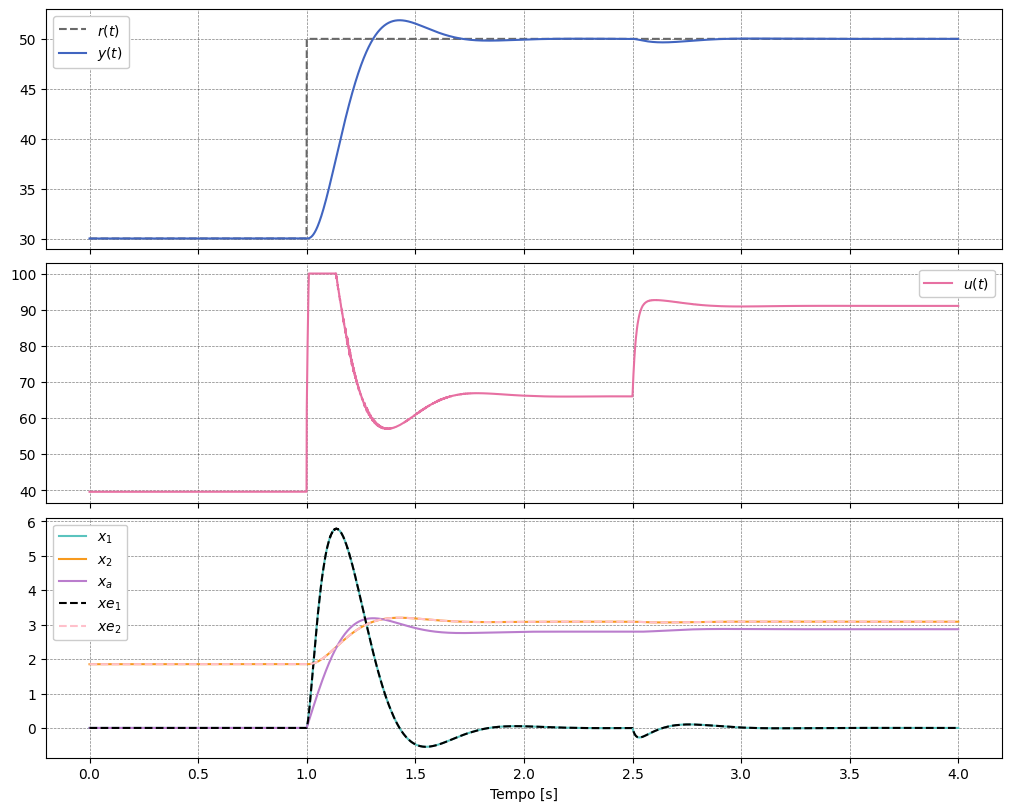

In [6]:
#Vetor de tempo:
ts = 1e-3
tdeg = 1.5
t = np.arange(0, 8/3*tdeg, ts)

#Ponto de operação e sinais de equilíbrio:
pop = 30
ueq = pop/ct.dcgain(ss)
xeq = ((np.linalg.inv(A)@(-B*ueq)).T[0])
X0 = np.hstack([[ueq], [pop], xeq, [0], xeq])

#Declaração do modelo:
SYSTEM = ct.NonlinearIOSystem(model_update, model_output, states=((2*len(A))+1), name='SYSTEM', inputs = ('r', 'd'), outputs = out, params=X0)

#Vetor de referência:
setpoint = 50
r = np.hstack([np.ones(int(2/3*tdeg/ts))*pop, np.ones(int(2*tdeg/ts))*setpoint])

#Perturbação no sistema
d = np.hstack([np.zeros(int(5/3*tdeg/ts)), np.ones(int(tdeg/ts))*(-0.5*setpoint)])

#Simulação do sistema:
t, sol = ct.input_output_response(SYSTEM, t, [r, d], np.zeros((2*len(A))+1)) 

#Demultiplex da saída:
u = sol[0]
y = sol[1]
x = sol[2:]

#Plot das curvas:
labels = []
for i in range(len(A)):
    labels.append(f'$x_{i+1}$')
labels.append('$x_a$')
for i in range(len(A)):
    labels.append(f'$xe_{i+1}$')
plt.subplots(3, 1, sharex=True, constrained_layout = True)
plt.subplot(3, 1, 1)
plt.plot(t, r, color='C3', linestyle='dashed', label='$r(t)$')
plt.plot(t, y, color='C0', label='$y(t)$')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(t, u, color='C1', label='$u(t)$')
plt.legend()
plt.subplot(3, 1, 3)
for i in range(len(x)):
    if(i<=len(A)):
        plt.plot(t, x[i], color=colors[i+2], label=labels[i])
    else:
        plt.plot(t, x[i], color=colors[i+2], linestyle='dashed', label=labels[i])
plt.xlabel('Tempo [s]')
plt.legend()
plt.show()